In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Imports
import yfinance as yf

sns.set_theme(style="whitegrid")  # Apply Seaborn's theme

# Framework
from dataclasses import dataclass


@dataclass
class Apartment:
    square_meters: int
    price_per_sq_m_zl: int

    @property
    def price(self) -> int:
        return self.square_meters * self.price_per_sq_m_zl


@dataclass
class Mortgage:
    pv: int
    years: int
    i: float  # APR, f.e. 7%
    m: int = 12  # payment periods per year

    @property
    def periods(self) -> int:
        return self.years * self.m

    @property
    def pmt(self) -> int:
        i = self.i / 100
        per_period_annuity_factor = self.m / (self.m + i)
        per_year_factor = self.m * (1 - pow(per_period_annuity_factor, self.periods))
        return self.pv * i / per_year_factor

    @property
    def fv(self) -> int:
        return self.pmt * self.periods


class Costs:
    def __init__(
            self,
            apt: Apartment, mortgage: Mortgage,
            realtor_rate: int,
            bank_provision_rate: int, bank_promise_zl: int,
            unexpected_costs_zl: int):
        self.notary_zl = 1010 + 0.004 * (apt.price - 60000)
        self.realtor_costs = apt.price * realtor_rate / 100
        self.bank_provision_zl = mortgage.pv * bank_provision_rate / 100
        self.bank_promise_zl = bank_promise_zl
        self.unexpected_costs_zl = unexpected_costs_zl
        self.mortgage_register_zl = 100 + 200 + 200 + 250

    @property
    def all_zl(self) -> int:
        return self.notary_zl + self.realtor_costs + self.bank_provision_zl + self.bank_promise_zl + self.unexpected_costs_zl + self.mortgage_register_zl


[*********************100%***********************]  1 of 1 completed


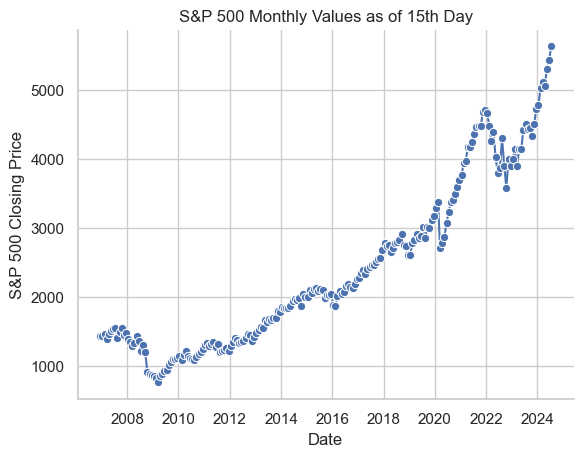

In [32]:
# S&P 500

# Step 1: Download S&P 500 data using yfinance
ticker = "^GSPC"  # S&P 500 index ticker
sp500_data = yf.download(ticker, start="2006-12-01", end="2024-08-01", interval="1d")

# Step 2: Convert index to DateTimeIndex for easier manipulation
sp500_data.index = pd.to_datetime(sp500_data.index)

# Step 3: Create a new column to store the day of the month
sp500_data['Day'] = sp500_data.index.day

# Step 4: Filter the data to keep only rows corresponding to the 15th day of each month
monthly_15th = sp500_data[sp500_data['Day'] == 15]

# Step 5: Handle cases where the 15th is a non-trading day
# (Find the closest previous trading day)
all_months = pd.date_range(start=sp500_data.index.min(), end=sp500_data.index.max(), freq='MS')
monthly_values = []

for month_start in all_months:
    month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(1))
    closest_15th = month_days[month_days.day == 15][0]

    if closest_15th not in sp500_data.index:
        closest_15th = sp500_data.loc[:closest_15th].index[-1]

    monthly_values.append(sp500_data.loc[closest_15th])

# Convert the list to a DataFrame
sp_500_monthly = pd.DataFrame(monthly_values)
sp_500_monthly.set_index(pd.to_datetime(pd.to_datetime(sp_500_monthly.index).strftime("%Y-%m-15")), inplace=True)

# Create the line plot
ax = sns.lineplot(x=sp_500_monthly.index, y=sp_500_monthly['Close'], marker='o')

# Set titles and labels using Seaborn's interface
ax.set_title('S&P 500 Monthly Values as of 15th Day')
ax.set_xlabel('Date')
ax.set_ylabel('S&P 500 Closing Price')

# Show the plot
sns.despine()  # Remove the top and right spines for a cleaner look
plt.show()

,price
year,
2006-12-01,8560
2007-01-01,8656
2007-02-01,9017
2007-03-01,9296
2007-04-01,9366
...,...
2024-03-01,17561
2024-04-01,17442
2024-05-01,17825


,price
count,212.000000
mean,10227.863208
std,2372.581000
min,8125.000000
25%,8564.500000
50%,9167.500000
75%,11370.750000
max,17942.000000


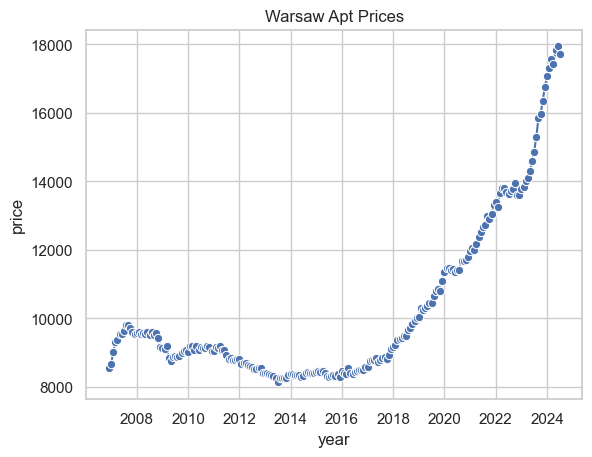

In [33]:
# Warsaw Apartment data
warsaw_apt_data = pd.read_csv("../datasources/warsaw_real_estate.csv", names=["price"], index_col=0)

warsaw_apt_data.index = warsaw_apt_data.index.map(lambda x: x.split("(")[0].strip())
warsaw_apt_data.index = pd.to_datetime(warsaw_apt_data.index, format="%a %b %d %Y %H:%M:%S GMT%z", utc=True).date
warsaw_apt_data.index.name = "year"

warsaw_apt_data.price = warsaw_apt_data.price.map(lambda x: x.replace(" ", ""))
warsaw_apt_data.price = pd.to_numeric(warsaw_apt_data.price, errors='coerce')
warsaw_apt_data.index = pd.to_datetime(warsaw_apt_data.index)

# Print
display(warsaw_apt_data)
display(warsaw_apt_data.describe())

# Plot
ax = sns.lineplot(x=warsaw_apt_data.index, y=warsaw_apt_data.price, marker='o')
ax.set_title('Warsaw Apt Prices')
plt.show()

warsaw_apt_data_year = warsaw_apt_data.groupby(warsaw_apt_data.index.year).mean()

,yoy,compounded
year,,
2007,102.5,1.000000
2008,104.2,1.042000
2009,103.5,1.078470
2010,102.6,1.106510
2011,104.3,1.154090
2012,103.7,1.196791
2013,100.9,1.207563
2014,100.0,1.207563
2015,99.1,1.196695


,yoy,compounded
count,18.000000,18.000000
mean,103.555556,1.271355
std,3.828718,0.223519
min,99.100000,1.000000
25%,101.700000,1.162946
50%,103.000000,1.207563
75%,104.075000,1.293227
max,114.400000,1.809395


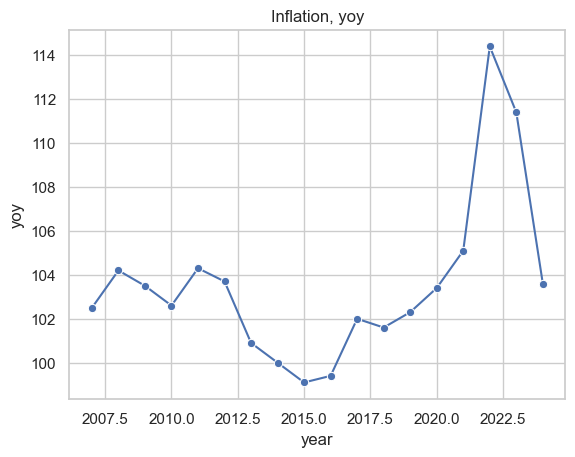

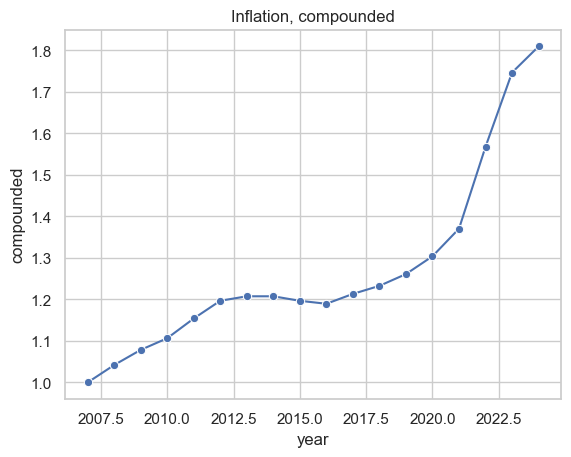

In [34]:
# Inflation
inflation = pd.DataFrame(
    columns=["year", "yoy"],
    data=[
        (2007, 102.5),
        (2008, 104.2),
        (2009, 103.5),
        (2010, 102.6),
        (2011, 104.3),
        (2012, 103.7),
        (2013, 100.9),
        (2014, 100.0),
        (2015, 99.1),
        (2016, 99.4),
        (2017, 102.0),
        (2018, 101.6),
        (2019, 102.3),
        (2020, 103.4),
        (2021, 105.1),
        (2022, 114.4),
        (2023, 111.4),
        (2024, 103.6),
    ]
)
inflation.set_index("year", inplace=True)

inflation.loc[2007, "compounded"] = 1
for i in range(2008, 2007 + len(inflation)):
    inflation.loc[i, "compounded"] = inflation.loc[i-1, "compounded"] * (inflation.loc[i, "yoy"] / 100)

# Print
display(inflation)
# Print basic stats
display(inflation.describe())
# Plot
ax = sns.lineplot(x=inflation.index, y=inflation.yoy, marker="o")
ax.set_title('Inflation, yoy')
plt.show()

ax = sns.lineplot(x=inflation.index, y=inflation.compounded, marker="o")
ax.set_title('Inflation, compounded')
plt.show()


In [63]:
# Historical rent

rent_per_m2 = pd.DataFrame(
    columns=["year", "zl_per_m2"],
    data=[
        (2007, 48),
        (2008, 50),
        (2009, 45),
        (2010, 46),
        (2011, 47),
        (2012, 46),
        (2013, 46),
        (2014, 47),
        (2015, 48),
        (2016, 51),
        (2017, 53),
        (2018, 54),
        (2019, 58),
        (2020, 60),
        (2021, 64),
        (2022, 75),
        (2023, 80),
        (2024, 82),
    ]
)
rent_per_m2.set_index("year", inplace=True)

display(rent_per_m2)



,zl_per_m2
year,
2007,48
2008,50
2009,45
2010,46
2011,47
2012,46
2013,46
2014,47
2015,48


In [67]:
# Framework.

class Framework: 
    def __init__(self, 
                 sq_m: int, 
                 start_year: int,
                 end_year: int,
                 start_year_3m_wibor: float,
                 bank_margin_wibor: float,
                 
                 ):
        self.sq_m = sq_m
        self.start_year = start_year
        self.end_year = end_year
        self.start_year_3m_wibor = start_year_3m_wibor
        self.bank_margin_wibor = bank_margin_wibor
        pass
    
    def simulate_mortgage(self):
        avg_sqm_price_start_year = warsaw_apt_data_year.loc[self.start_year].iloc[0,]

        apt = Apartment(
            square_meters=75,
            price_per_sq_m_zl=avg_sqm_price_start_year,
        )
        down_payment = apt.price * 0.10

        mortgage = Mortgage(
            years=self.end_year - self.start_year,
            i=self.start_year_3m_wibor + self.bank_margin_wibor,
            pv=apt.price - down_payment
        )

        # TODO. Add various insurances (for example, from https://www.mbank.pl/download/taryfy/TPiO_03.04.2006.pdf?noredir)
        mortgage_costs = Costs(
            apt=apt, mortgage=mortgage,
            realtor_rate=2,
            bank_provision_rate=2,
            bank_promise_zl=150,
            unexpected_costs_zl=150
        )

        day_zero_costs = down_payment + mortgage_costs.all_zl

        print(f"Apt. price: {apt.price} for {apt.square_meters} sq.m., {apt.price_per_sq_m_zl} zl/m2")
        print(f"Down payment: {down_payment:.2f}")
        print(f"Day zero down payment + all mortgage costs: {day_zero_costs:.2f}")
        print(f"Overpay on day 0: {day_zero_costs - down_payment:.2f}")
        
        print("\n")
        
        print(f"PMT: {mortgage.pmt:.2f}")
        print(f"Loan PV: {mortgage.pv:.2f}")
        print(f"Loan FV: {mortgage.fv:.2f}")
        
        print("\n")
        
        total_fv = mortgage.fv + day_zero_costs
        total_overpay = total_fv - apt.price
        print(f"FV Total: {total_fv:.2f}")
        print(f"Total overpay: {total_overpay:.2f}")
        
        sell_price = apt.square_meters * warsaw_apt_data_year.loc[self.end_year].iloc[0,]
        profit = sell_price - total_fv
        avg_yearly_yield = (profit / total_fv) * 100
        print(f"Sell price: {sell_price:.2f}")
        print(f"Profit: {profit:.2f}")
        print(f"Avg yearly yield: {avg_yearly_yield:.2f}")
        
        self.apt = apt
        self.sell_price = sell_price
        self.day_zero_costs = day_zero_costs
        
    def simulate_investment_sp_500(self):
        monthly_rent = (self.apt.square_meters * rent_per_m2).loc[self.start_year:self.end_year]
        monthly_rent.rename({"zl_per_m2": "monthly"}, axis="columns", inplace=True)
        print("\n")
        print(f"Monthly rent, sum: {12 * monthly_rent.monthly.sum():.2f}")
        display(monthly_rent)
        
        monthly_money_left = monthly_rent.monthly.max() - monthly_rent

        monthly_investements = []

        for year in range(self.start_year, self.end_year):
            for month in range(1, 12):
                monthly_investements.append(
                    (f"{year}-{month}", monthly_money_left.loc[year].iloc[0,] / sp_500_monthly.Close.loc[f"{year}-{month}"].iloc[0,])
                )
        
        sp_500_day_zero_investment = self.day_zero_costs / sp_500_monthly.Close.loc[f"{self.start_year}-01"].iloc[0,]
        sp_500_shares = sp_500_day_zero_investment + pd.DataFrame(monthly_investements).sum()[1]
        sp_500_total_assets = sp_500_shares * sp_500_monthly.Close.loc[f"{self.end_year}-01"].iloc[0,]
        
        print("\n")
        print(f"Total asset, S&P500: {sp_500_total_assets:.2f}")
        diff = sp_500_total_assets - self.sell_price
        print(f"d over sell price: {diff:.2f}")
        print(f"d% over sell price: {diff*100/self.sell_price:.2f}%")
        

In [68]:

run_2007_2024 = Framework(
    sq_m=75,
    start_year=2007,
    end_year=2024,
    start_year_3m_wibor=5.56,
    bank_margin_wibor=2.00,
)

run_2007_2024.simulate_mortgage()
run_2007_2024.simulate_investment_sp_500()


Apt. price: 709256.25 for 75 sq.m., 9456.75 zl/m2
Down payment: 70925.62
Day zero down payment + all mortgage costs: 102534.39
Overpay on day 0: 31608.76


PMT: 5567.70
Loan PV: 638330.62
Loan FV: 1135811.74


FV Total: 1238346.13
Total overpay: 529089.88
Sell price: 1316367.86
Profit: 78021.73
Avg yearly yield: 6.30


Monthly rent, sum: 900000.00


,monthly
year,
2007,3600
2008,3750
2009,3375
2010,3450
2011,3525
2012,3450
2013,3450
2014,3525
2015,3600




Total asset, S&P500: 1491519.08
d over sell price: 175151.22
d% over sell price: 13.31%


In [69]:

run_2007_2021 = Framework(
    sq_m=75,
    start_year=2007,
    end_year=2021,
    start_year_3m_wibor=5.56,
    bank_margin_wibor=2.00,
)

run_2007_2021.simulate_mortgage()
run_2007_2021.simulate_investment_sp_500()

Apt. price: 709256.25 for 75 sq.m., 9456.75 zl/m2
Down payment: 70925.62
Day zero down payment + all mortgage costs: 102534.39
Overpay on day 0: 31608.76


PMT: 6169.48
Loan PV: 638330.62
Loan FV: 1036471.96


FV Total: 1139006.35
Total overpay: 429750.10
Sell price: 941825.00
Profit: -197181.35
Avg yearly yield: -17.31


Monthly rent, sum: 686700.00


,monthly
year,
2007,3600
2008,3750
2009,3375
2010,3450
2011,3525
2012,3450
2013,3450
2014,3525
2015,3600




Total asset, S&P500: 677274.76
d over sell price: -264550.24
d% over sell price: -28.09%


In [70]:
run_2010_2021 = Framework(
    sq_m=75,
    start_year=2010,
    end_year=2021,
    start_year_3m_wibor=5.56,
    bank_margin_wibor=2.00,
)

run_2010_2021.simulate_mortgage()
run_2010_2021.simulate_investment_sp_500()

Apt. price: 685018.75 for 75 sq.m., 9133.583333333334 zl/m2
Down payment: 68501.88
Day zero down payment + all mortgage costs: 99092.66
Overpay on day 0: 30590.79


PMT: 6892.60
Loan PV: 616516.88
Loan FV: 909823.78


FV Total: 1008916.44
Total overpay: 323897.69
Sell price: 941825.00
Profit: -67091.44
Avg yearly yield: -6.65


Monthly rent, sum: 558000.00


,monthly
year,
2010,3450
2011,3525
2012,3450
2013,3450
2014,3525
2015,3600
2016,3825
2017,3975
2018,4050




Total asset, S&P500: 601917.22
d over sell price: -339907.78
d% over sell price: -36.09%
